# CS5014 Machine Learning 
##### Credits: 50% of the coursework

## Aims


The objectives of this assignment are:

* deepen your understanding of linear regression and logistic regression
* gain experience in implementing learning algorithms 
* gain experience in evaluating machine learning algorithms
* gain experience in hyper-parameter tuning


## Set-up

You are **only allowed** to use the following imported packages for this practical. No off-the-shelf machine learning packages such as _scikit-learn_ are allowed. 


In [4]:
# Install necessary dependencies
%pip install matplotlib pandas autograd
# if you use jupyter-lab, switch to %matplotlib inline instead
%matplotlib inline
# %matplotlib notebook
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
import autograd.numpy as np  # Thinly-wrapped numpy
from autograd import grad    # The only autograd function you may ever need
import autograd.numpy.linalg as linalg
import pandas as pd

Note: you may need to restart the kernel to use updated packages.


The following method computes the gradient of a given function $f$ at an input location `initial`. Note that the finite difference method suffers from truncating and rounding errors and can be slow for large-scale machine learning models. It should never be directly used in a gradient descent algorithm. But it can be very useful to check your gradient derivation and implementation. You should always check your gradients before using them.

In [5]:
def finite_difference_gradient(f, initial, eps=1e-6):
    initial = np.array(initial, dtype=float)
    n = len(initial)
    output = np.zeros(n)
    for i in range(n):
        ei = np.zeros(n)
        ei[i] = 1
        f1 = f(initial + eps * ei)
        f2 = f(initial - eps * ei)
        output[i] = (f1-f2)/(2*eps)
    output = output.reshape(n,1)
    return output

## Question 1 (Logistic regression)

In this question, we are going to implement a logistic regression model to do binary classification on a simulated dataset. The dataset's input feature are four-dimensional vectors $\mathbf{x}^{(i)} \in \mathbb{R}^4$ and as expected the targets are binary, *i.e.* $y^{(i)} \in \{0, 1\}$. 


The dataset $\{\mathbf{x}^{(i)}, y^{(i)}\}$ is imported below for you:
* ``dataset1``: 2000 observations and each input $\mathbf{x}$ has 4 features 
* and the last column is the target ${y}^{(i)}$
* the dataset is then split into training and testing parts

In [6]:
# read in dataset1
dataset1_df = pd.read_csv('./datasets/dataset1.csv', header=0)
dataset1 = np.array(dataset1_df)
d1X, d1Y = dataset1[:, 0:4], dataset1[:, -1]
# split the data into training and testing 
# the training dataset has the first 1500 observation; 
# in practice, you should randomly shuffle before the split
d1_xtrain, d1_ytrain = d1X[0:1500, :], d1Y[0:1500]
# the testing dataset has the last 500
d1_xtest, d1_ytest = d1X[1500:, :], d1Y[1500:]

As suggested in the lecture, it is convenient to introduce dummy variables of ones to avoid learning the bias separately.

In [7]:
d1_xtrain_dummy = np.column_stack((np.ones(d1_xtrain.shape[0]), d1_xtrain))
d1_xtest_dummy = np.column_stack((np.ones(d1_xtest.shape[0]), d1_xtest))

### Task 1.1 Implementation of logistic regression

Your task here is to implement a gradient descent based algorithm to train a logistic regression model. For this task, you cannot use `autograd`'s auto-differentiation method (*i.e.* the imported `grad` method). You will be guided to finish the task step by step. 

First, implement the `sigmoid` function:

$$\sigma(z) = \frac{1}{1+e^{-z}}$$

In [19]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

Second, implement the cross-entropy loss and its gradient. You may want to refer to the lecture slides for the details. Recall the binary **C**ross **E**ntropy (CE) _loss_ is 


$$
L(\mathbf{w})=  \frac{1}{n}\sum_{i=1}^n -{y^{(i)}} \ln \sigma^{(i)}- (1- y^{(i)}) \ln (1-\sigma^{(i)})
$$

where $\sigma^{(i)} =\sigma(\mathbf{w}^\top\mathbf{x}^{(i)} + b).$

In [20]:
def cross_entropy_loss(w, X, y):
    loss_sum = 0
    n = X.shape[0]
    
    for i in range(n):
        weighted_sum = np.dot(w.T, X[i])
        sigma_transformed = sigmoid(weighted_sum)
        loss = -y[i] * np.log(sigma_transformed) - (1 - y[i]) * np.log(1 - sigmoid(sigma_transformed))
        loss_sum += loss
        
    return loss_sum / n

In [21]:
def gradient_ce_loss(w, X, y):
    n, d = X.shape
    gradw = np.zeros(d)
    
    for i in range(n):
        weighted_sum = np.dot(w.T, X[i])
        sigma_transformed = sigmoid(weighted_sum)
        gradient = (y[i] - sigma_transformed) * X[i]
        gradw += gradient
        
    return -(gradw / n)

Now, implement the gradient descent algorithm below. Before that, you should consider testing our gradient method before using it in the training algorithm. 

In [22]:
def logistic_regression_train(X, y, lr, tol, maxIters):
    n, d = X.shape 
    w0 = np.zeros(d)
    l0 = cross_entropy_loss(w0, X, y)
    losses = [l0]

    for i in range(maxIters):
        w0 -= lr * gradient_ce_loss(w0, X, y)
        l = cross_entropy_loss(w0, X, y)
        losses.append(l)
        relative_change = np.abs(losses[-1] - losses[-2]) / l0
        
        if relative_change < tol:
            break
        
    return w0, losses

After you finish implementing all the above methods, use your learning algorithm to train a logistic regression model on the training dataset and answer the following questions:

* plot the learning curve
* report the learnt parameter with learning rate 0.1, `tol=1e-5` and `maxIters=2000`

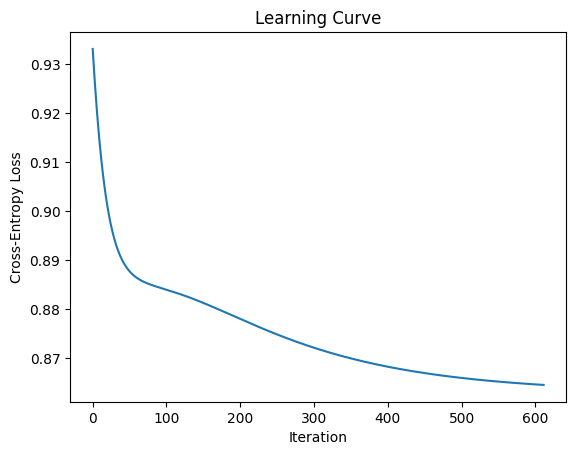

Learned weights: [-2.09076385  1.54306227 -0.84936166  0.32742396 -0.0434615 ]


In [23]:
lr = 0.1
tol = 1e-5
maxIters = 2000
w, losses = logistic_regression_train(d1_xtrain_dummy, d1_ytrain, lr, tol, maxIters)

plt.plot(losses)
plt.title('Learning Curve')
plt.xlabel('Iteration')
plt.ylabel('Cross-Entropy Loss')
plt.show()

print(f"Learned weights: {w}")

### Task 1.2 Testing performance

Implement a prediction method that takes as input the features together with the learnt parameter and outputs the predicted labels.

In [24]:
def predict_logistic_regression(w, X):
    n, d = X.shape 
    predicted_labels = np.zeros(n, dtype=int)
    weighted_sum = np.dot(X, w)
    probabilities = sigmoid(weighted_sum)
    
    for i in range(n):
        if probabilities[i] > 0.5:
            predicted_labels[i] = 1
        else:
            predicted_labels[i] = 0
            
    return predicted_labels

Report the test performance on the unseen test dataset.

In [25]:
predictions = predict_logistic_regression(w, d1_xtest_dummy)

print(f"Accuracy: {np.mean(predictions == d1_ytest)}")

Accuracy: 0.868


### Task 1.3 Regularisation

In this sub-task, you are going to apply $L_2$ regularisation to the logistic regression model. The regularised loss is

$$
L(\mathbf{w})=  \frac{1}{n}\sum_{i=1}^n -{y^{(i)}} \ln \sigma^{(i)}- (1- y^{(i)}) \ln (1-\sigma^{(i)}) + \frac{\lambda}{2} \mathbf{w}^\top\mathbf{w}
$$

* where $\lambda >0$ is the regularisation hyperparameter

* note that we do not usually apply penalty on the bias parameter $b$

Implement the following method that fits a regularised logistic regression model with a given $\lambda$.

In [32]:
def logistic_regression_reg_train(X, y, lr, lam, tol, maxIters):
    n, d = X.shape 
    w0 = np.zeros(d)
    l0 = cross_entropy_loss(w0, X, y)
    losses = [l0]
    
    for i in range(maxIters):
        gradient = gradient_ce_loss(w0, X, y)
        regularized_gradient = gradient + lam * w0
        w0 -= lr * regularized_gradient
        l = cross_entropy_loss(w0, X, y) + (lam / 2 * np.sum(w ** 2))
        losses.append(l)
        relative_change = np.abs(losses[-1] - losses[-2]) / l0
        
        if relative_change < tol:
            break
        
    return w0, losses

Complete and report the following two results
* report the training loss and learnt parameter by setting $\lambda=0.01$
* report the testing performance for the regularised logistic regression model with $\lambda=0.01$

In [33]:
lr = 0.1
lam = 0.01
tol = 1e-5
maxIters = 2000
w, losses = logistic_regression_reg_train(d1_xtrain_dummy, d1_ytrain, lr, lam, tol, maxIters)
predictions = predict_logistic_regression(w, d1_xtest_dummy)

print(f"Learned weights: {w}")
print(f"Training loss: {losses[-1]}")
print(f"Accuracy: {np.mean(predictions == d1_ytest)}")

Learned weights: [-1.83042095  1.18598358 -0.66192679  0.25359191 -0.03803117]
Training loss: 0.8912767854711426
Accuracy: 0.866


### Task 1.4 Stochastic gradient descent 


Implement a stochastic gradient descent algorithm with a mini-batch size of 1. You should consider shuffling the training dataset to improve the convergence speed. 

It is a good idea to implement a decaying learning rate. One possible choice is 
$$\gamma_t = \frac{\gamma_0}{1 + \tau \gamma_0 t}$$
* where $\gamma_0 >0$ is the initial learning rate,
* and $\tau \geq 0$ is a tuning parameter, *e.g.* $\tau = 0.1$

After implementing the algorithm, use it to train the logistic regression model. Compare the performance with the batch learning algorithm.

In [48]:
def logistic_regression_reg_sgd_train(X, y, lam, gamma0, tau, tol, maxIters):
    n, d = X.shape 
    w0 = np.zeros(d)
    losses = []

    for i in range(maxIters):
        permutation = np.random.permutation(n)
        X_shuffled = X[permutation]
        y_shuffled = y[permutation]
        
        lr = gamma0 / (1 + tau * i)
        
        for j in range(n):
            weighted_sum = np.dot(w0.T, X_shuffled[j])
            sigma_transformed = sigmoid(weighted_sum)
            gradient = (sigma_transformed - y_shuffled[j]) * X_shuffled[j]
            regularized_gradient = gradient + lam * w0
            w0 -= lr * regularized_gradient
            
        l = cross_entropy_loss(w0, X, y) + (lam / 2 * np.sum(w0 ** 2))
        losses.append(l)
        
        if i > 0 and np.abs(losses[-1] - losses[-2]) < tol:
            break
    
    return w0

In [49]:
lam = 0.01
gamma = 1.0
tau = 0.1
tol = 1e-4
maxIters = 100
w = logistic_regression_reg_sgd_train(d1_xtrain_dummy, d1_ytrain, lam, gamma, tau, tol, maxIters)
predictions = predict_logistic_regression(w, d1_xtest_dummy)

print(f"Learned weights: {w}")
print(f"Accuracy: {np.mean(predictions == d1_ytest)}")

Learned weights: [-2.02174768  1.54976431 -0.74255281  0.05275981 -0.1030682 ]
Accuracy: 0.864


## Question 2 (Fixed basis expansion)



In this question, we are going to implement a fixed basis expansion regression model. The dataset for this question has a univariate feature $\mathbf{x}^{(i)} \in \mathbb{R}$ and as expected the target $y^{(i)} \in \mathbb{R}$ is real valued. 


The dataset is imported below for you:
* ``dataset2``: 1000 observations and each input ${x}^{(i)}$ is a scalar 
* and the last column is the target ${y}^{(i)}$
* the dataset is then split into training and testing parts

In [50]:
# read in dataset2
dataset2_df = pd.read_csv('./datasets/dataset2.csv', header=0)
dataset2 = np.array(dataset2_df)
d2X, d2Y = dataset2[:, 0], dataset2[:, -1]
# split the data into training and testing 
# the training dataset has the first 800 observation; 
# in practice, you should randomly shuffle before the split
d2_xtrain, d2_ytrain = d2X[0:800], d2Y[0:800]
# # the testing dataset has the last 500
d2_xtest, d2_ytest = d2X[800:], d2Y[800:]

The data is plotted below.

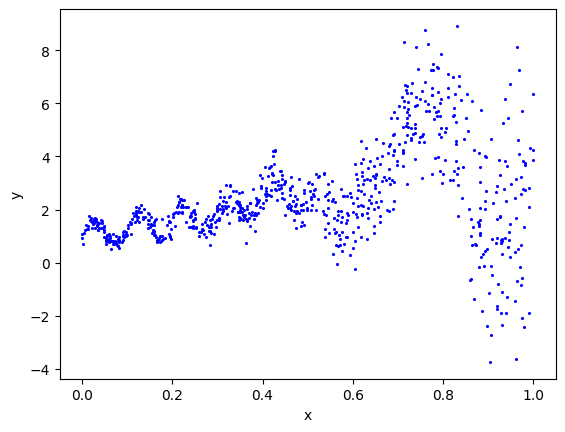

In [51]:
plt.scatter(d2_xtrain, d2_ytrain,  c ="blue", s=1.5)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Task 2.1 Basis function

Implement the radian-basis-function (rbf), 

$$\phi(x; \mu, s) = \exp\left \{- \frac{(x-\mu)^2}{2s} \right \}$$

In [52]:
def phi_rbf(x, mu, s):
    return np.exp(-((x - mu)**2) / (2 * s))

### Task 2.2 Fixed basis expansion regression

Implement the fixed basis expansion regression model. Specifically, you should 
* first apply $K$ fixed basis expansion on the input $\{x^{(i)}\}$ to form the expanded design matrix $\mathbf{\Phi}$
* then fit a regression model by a non-iterative algorithm (*i.e.* the normal equation method)

In [53]:
def fixed_basis_rbf_reg(X, y, mus, s):
    n = X.shape[0]
    m = len(mus)
    expanded_X = np.zeros((n, m + 1))
    
    for i in range(n):
        expanded_X[i, 0] = 1
        for j in range(m):
            expanded_X[i, j+1] = phi_rbf(X[i], mus[j], s)

    w = np.dot(np.linalg.pinv(np.dot(expanded_X.T, expanded_X)), np.dot(expanded_X.T, y))
    return w

Implement a prediction method `predict_rbf_reg`, that outputs the prediction $\hat{y}$ given input $x_{test}$. Note that the method should be able to predict outputs for multiple test inputs.

In [54]:
def predict_rbf_reg(X, w, mus, s):
    n = X.shape[0]
    m = len(mus)
    expanded_X = np.zeros((n, m + 1))
    
    for i in range(n):
        expanded_X[i, 0] = 1
        for j in range(m):
            expanded_X[i, j+1] = phi_rbf(X[i], mus[j], s)
            
    return np.dot(expanded_X, w)

Fit a fixed basis expansion regression model with $K=50$ fixed basis functions. The expansion locations $\mu$s should be within $x$'s range. And it is up to you how to choose them (*e.g.* they can be evenly placed within the range).

* try different settings (*e.g.* with different expansion location and scale $s$ choices)
* plot the fitted function (together with the training data) of your choice 
* and report the test error on your chosen model

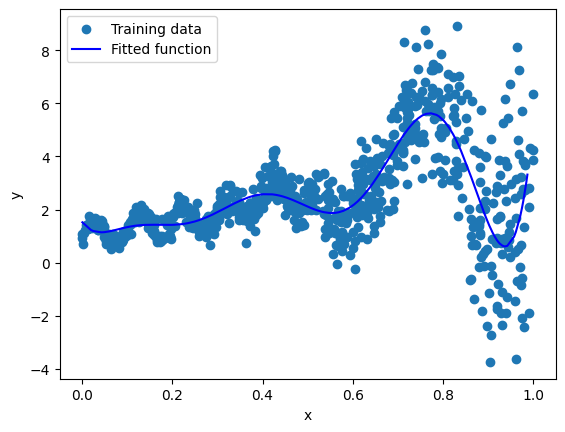

Test error: 1.3987884949573157


In [55]:
k = 50
min = np.min(d2_xtrain)
max = np.max(d2_xtrain)
mus = np.linspace(min, max, k)
s = 0.1
w = fixed_basis_rbf_reg(d2_xtrain, d2_ytrain, mus, s)
predictions = predict_rbf_reg(d2_xtest, w, mus, s)

sorted_indices = np.argsort(d2_xtest)
sorted_xtest = d2_xtest[sorted_indices]
sorted_predictions = predictions[sorted_indices]

plt.scatter(d2_xtrain, d2_ytrain, label='Training data')
plt.plot(sorted_xtest, sorted_predictions, color='blue', label='Fitted function')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

test_error = np.mean((predictions - d2_ytest) ** 2)

print(f"Test error: {test_error}")

### Task 2.3 Other basis function


Implement another basis function of your choice and fit the regression model. Plot the fitted result below.

Sigmoid as the basis function

In [63]:
def fixed_basis_sigmoid_reg(X, y, cens, s):
    n = X.shape[0]
    m = len(cens)
    expanded_X = np.zeros((n, m + 1))
    
    for i in range(n):
        expanded_X[i, 0] = 1  
        for j in range(m):
            weighted_sum = (X[i] - cens[j])
            expanded_X[i, j+1] = sigmoid((X[i] - cens[j]) / s)

    w = np.dot(np.linalg.pinv(np.dot(expanded_X.T, expanded_X)), np.dot(expanded_X.T, y))
    return w

In [64]:
def predict_sigmoid_reg(X, w, cens, s):
    n = X.shape[0]
    m = len(cens)
    expanded_X = np.zeros((n, m + 1))

    for i in range(n):
        expanded_X[i, 0] = 1 
        for j in range(m):
            expanded_X[i, j+1] = sigmoid((X[i] - cens[j]) / s)

    return np.dot(expanded_X, w)

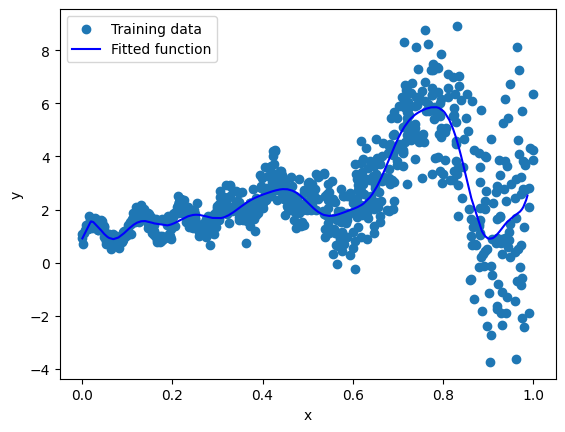

Test error: 1.4884861505579376


In [65]:
k = 50
min = np.min(d2_xtrain)
max = np.max(d2_xtrain)
cens = np.linspace(min, max, k)
s = 0.1
w = fixed_basis_sigmoid_reg(d2_xtrain, d2_ytrain, cens, s)
predictions = predict_sigmoid_reg(d2_xtest, w, cens, s)

sorted_indices = np.argsort(d2_xtest)
sorted_xtest = d2_xtest[sorted_indices]
sorted_predictions = predictions[sorted_indices]

plt.scatter(d2_xtrain, d2_ytrain, label='Training data')
plt.plot(sorted_xtest, sorted_predictions, color='blue', label='Fitted function')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

test_error = np.mean((predictions - d2_ytest) ** 2)

print(f"Test error: {test_error}")

Tanh as the basis function

In [74]:
def tanh(x):
    return np.tanh(x)

In [75]:
def fixed_basis_tanh_reg(X, y, cens, s):
    n = X.shape[0]
    m = len(cens)
    expanded_X = np.zeros((n, m + 1))
    
    for i in range(n):
        expanded_X[i, 0] = 1
        for j in range(m):
            expanded_X[i, j+1] = tanh(X[i] - cens[j] / s)

    w = np.dot(np.linalg.pinv(np.dot(expanded_X.T, expanded_X)), np.dot(expanded_X.T, y))
    return w

In [76]:
def predict_tanh_reg(X, w, cens, s):
    n = X.shape[0]
    m = len(cens)
    expanded_X = np.zeros((n, m + 1))
    
    for i in range(n):
        expanded_X[i, 0] = 1
        for j in range(m):
            expanded_X[i, j+1] = tanh(X[i] - cens[j] / s)
            
    return np.dot(expanded_X, w)

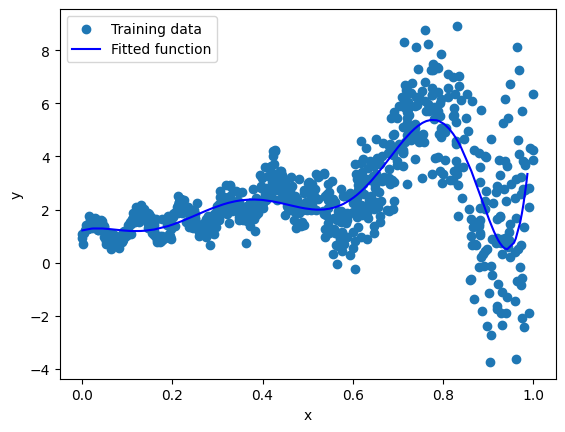

Test error: 1.3975745705957823


In [77]:
k = 50
min = np.min(d2_xtrain)
max = np.max(d2_xtrain)
cens = np.linspace(min, max, k)
s = 0.1
w = fixed_basis_tanh_reg(d2_xtrain, d2_ytrain, cens, s)
predictions = predict_tanh_reg(d2_xtest, w, cens, s)

sorted_indices = np.argsort(d2_xtest)
sorted_xtest = d2_xtest[sorted_indices]
sorted_predictions = predictions[sorted_indices]

plt.scatter(d2_xtrain, d2_ytrain, label='Training data')
plt.plot(sorted_xtest, sorted_predictions, color='blue', label='Fitted function')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

test_error = np.mean((predictions - d2_ytest) ** 2)

print(f"Test error: {test_error}")

Using ReLu

In [79]:
def relu(z):
    return np.maximum(0, z)

In [80]:
def fixed_basis_relu_reg(X, y, cens, s):
    n = X.shape[0]
    m = len(cens)
    expanded_X = np.zeros((n, m + 1))
    
    for i in range(n):
        expanded_X[i, 0] = 1
        for j in range(m):
            expanded_X[i, j+1] = relu(X[i] - cens[j] / s)

    w = np.dot(np.linalg.pinv(np.dot(expanded_X.T, expanded_X)), np.dot(expanded_X.T, y))
    return w

In [81]:
def predict_relu_reg(X, w, cens, s):
    n = X.shape[0]
    m = len(mus)
    expanded_X = np.zeros((n, m + 1))
    
    for i in range(n):
        expanded_X[i, 0] = 1
        for j in range(m):
            expanded_X[i, j+1] = relu(X[i] - cens[j] / s)
            
    return np.dot(expanded_X, w)

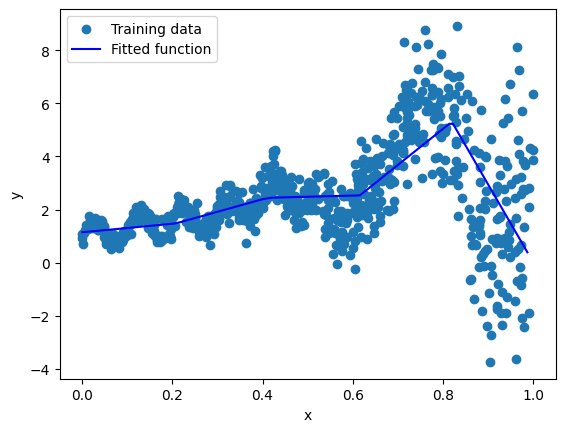

Test error: 1.7156009978283668


In [82]:
k = 50
min = np.min(d2_xtrain)
max = np.max(d2_xtrain)
cens = np.linspace(min, max, k)
s = 0.1
w = fixed_basis_relu_reg(d2_xtrain, d2_ytrain, cens, s)
predictions = predict_relu_reg(d2_xtest, w, cens, s)

sorted_indices = np.argsort(d2_xtest)
sorted_xtest = d2_xtest[sorted_indices]
sorted_predictions = predictions[sorted_indices]

plt.scatter(d2_xtrain, d2_ytrain, label='Training data')
plt.plot(sorted_xtest, sorted_predictions, color='blue', label='Fitted function')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

test_error = np.mean((predictions - d2_ytest) ** 2)

print(f"Test error: {test_error}")

### Task 2.4 Advanced task (extension*)

We assume the noise scale is a constant for an ordinary linear regression model. However, the noise scale for this dataset is not homogenous: it increases as $x$ gets larger. This is known as heteroscedasticity. Fit a fixed basis regression model that can also learn the adapting noise scale. You are allowed to use auto-differentiation for this question. Explain your model and report your findings in appropriate formats such as plots.

## Submission
Hand in via MMS: the completed jupyter notebook. Your notebook should be reproducible.



## Marking
Your submission will be marked as a whole. 

* to get a grade above 7, you are expected to finish at least Task 1.1-1.2 to a good standard
* to get a grade above 10 and up to 13, you are expected to complete Task 1.1-1.4 to a good standard
* to get a grade above 13 and up to 17, you are expected to complete all tasks except 2.3 and 2.4 to a good standard
* to achieve a grade of 17-18, you are expected to finish all tasks except Task 2.4 flawlessly 
* to get 18+, you are expected to attempt all questions flawlessly


Marking is according to the standard mark descriptors published in the Student Handbook at:

https://info.cs.st-andrews.ac.uk/student-handbook/learning-teaching/feedback.html#GeneralMarkDescriptors


You must reference any external sources used. Guidelines for good academic practice are outlined in the student handbook at https://info.cs.st-andrews.ac.uk/student-handbook/academic/gap.html
